In [1]:
import torch
import os
from pathlib import Path
import time
import numpy as np
import pandas as pd
import neurokit2 as nk
from captum.attr import Saliency
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore") # gets rid of anoying warnings that saliency-requires-grad-value is not set

# import own files
import config
import net_utils as nu
from focal_loss import CrossEntropyFocalLoss

model_name = "XResNet50-FL-21-06"

saliency_folder = os.path.join(config.OUT_FOLDER, 'saliency_maps_as_numpy')
if not os.path.exists(saliency_folder):
        Path(saliency_folder).mkdir(parents=True, exist_ok=True)

In [2]:

def get_samples_for_age_bin_and_patients(dataloader):
    sample_id_to_crop_list = {}
    sample_id_to_age_bin = {}
    age_bin_to_crop_list = {}
    for batch in dataloader:
        x_s = batch[0]
        y_s = batch[1]
        id_s = batch[2]
        for x, y, sample_id in zip(x_s, y_s, id_s):
            age_bin = y.detach().argmax(dim=0).item() + 1
            crop = x.unsqueeze(dim=0)
            sample_id = sample_id.detach().item()
            sample_crops = sample_id_to_crop_list.setdefault(sample_id, [])
            sample_crops.append(crop)
            sample_id_to_crop_list[sample_id] = sample_crops
            sample_id_to_age_bin[sample_id] = age_bin
            age_bin_crops = age_bin_to_crop_list.setdefault(age_bin, [])
            age_bin_crops.append(crop)
            age_bin_to_crop_list[age_bin] = age_bin_crops

    return sample_id_to_crop_list, age_bin_to_crop_list, sample_id_to_age_bin


# fetch the training set
train_dl = torch.load(os.path.join(config.DATALOADER_FOLDER, 'train' + '_DL.pt'))

# get crops per age bin and patient of the training set
sample_id_to_crop_list, age_bin_to_crop_list, sample_id_to_age_bin = get_samples_for_age_bin_and_patients(train_dl)


In [3]:
# load model
nn = nu.XResNet50(CrossEntropyFocalLoss(gamma=0.7), lr=0.0001)
saved_params = torch.load(os.path.join(config.TARGET_FOLDER, model_name))
nn.load_state_dict(saved_params)
nn.eval()

# apply saliency to the model
saliency = Saliency(nn)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 1


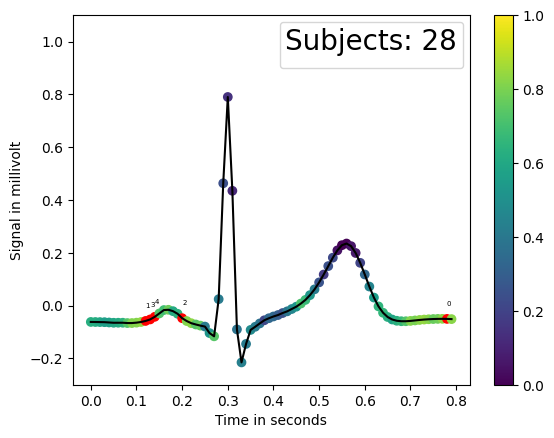

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 2


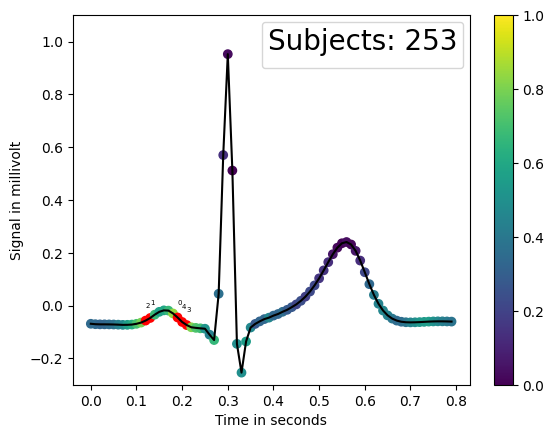

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 3


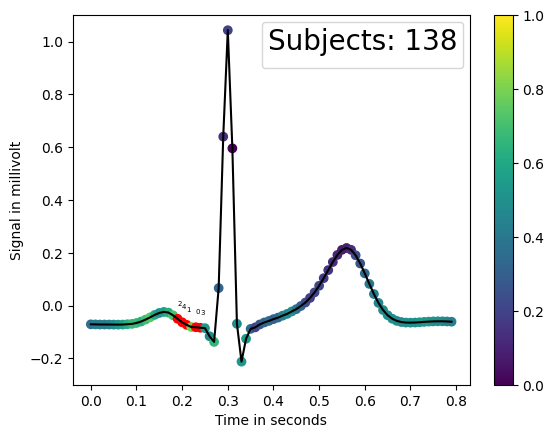

Number of ununsable crops after ecg-cleaning for subject 244: 18


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 4


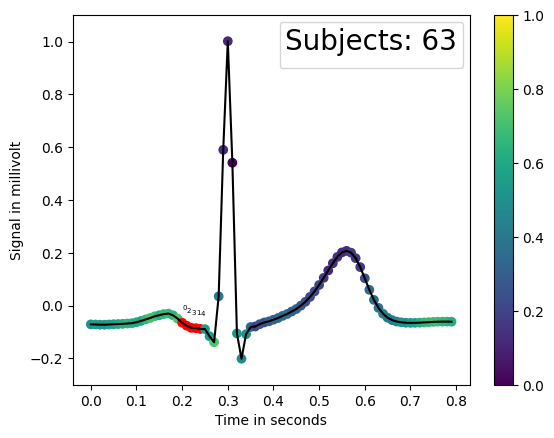

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 5


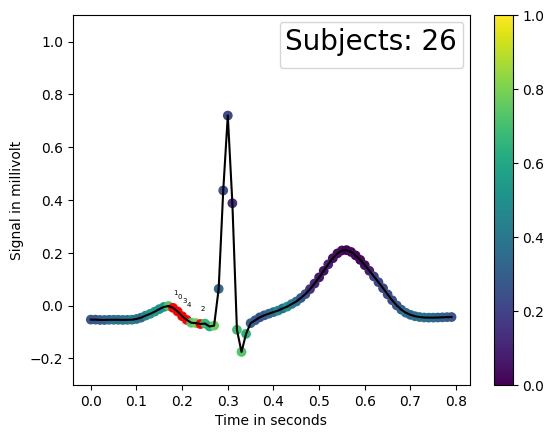

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 6


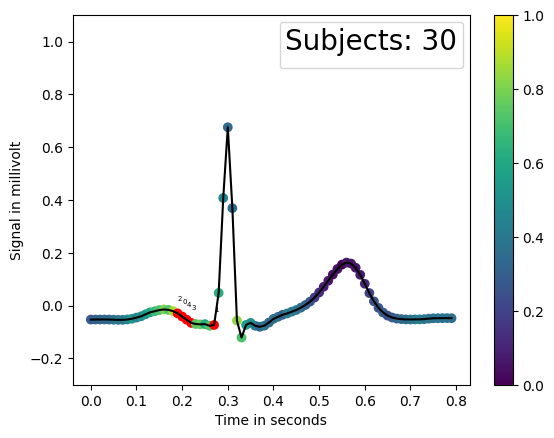

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 7


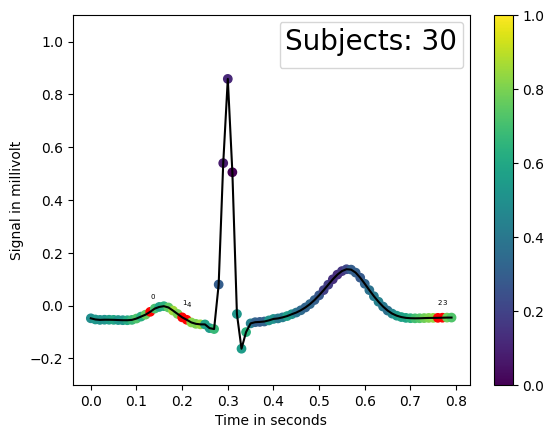

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 8


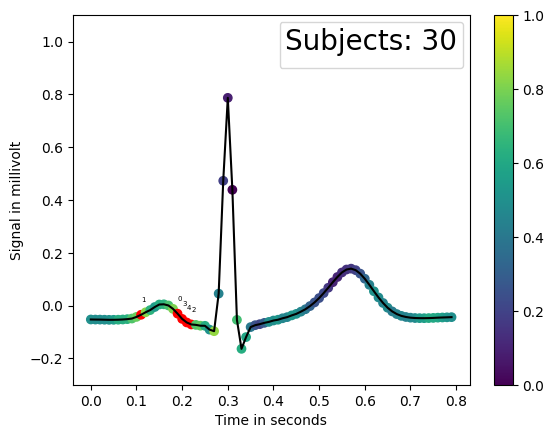

Number of ununsable crops after ecg-cleaning for subject 365: 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 9


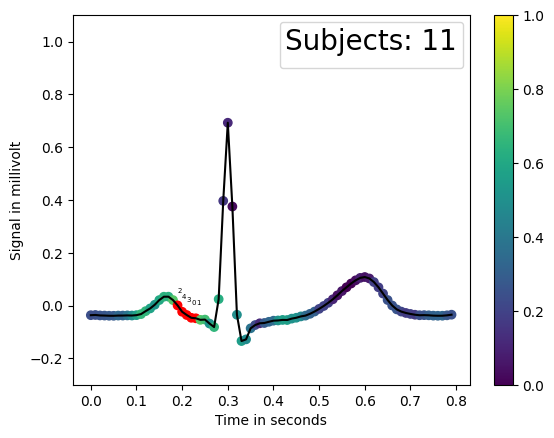

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 10


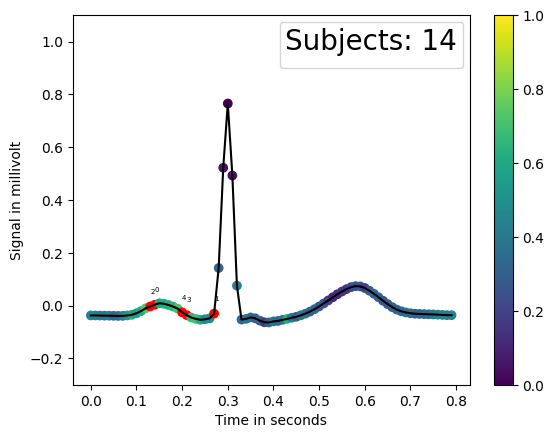

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 11


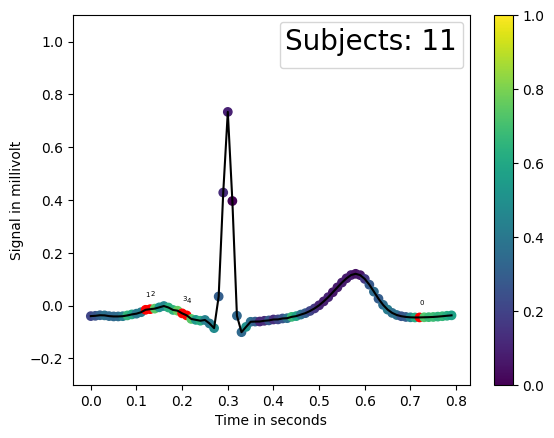

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 12


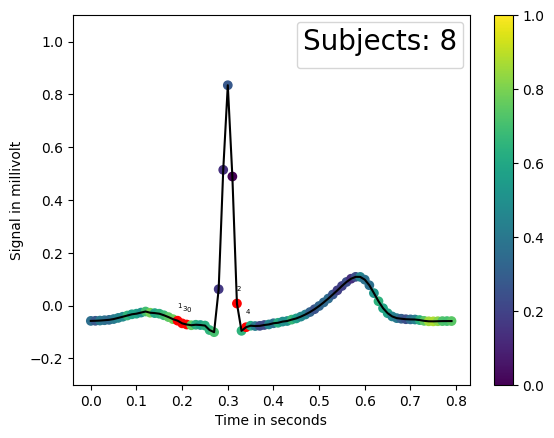

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 13


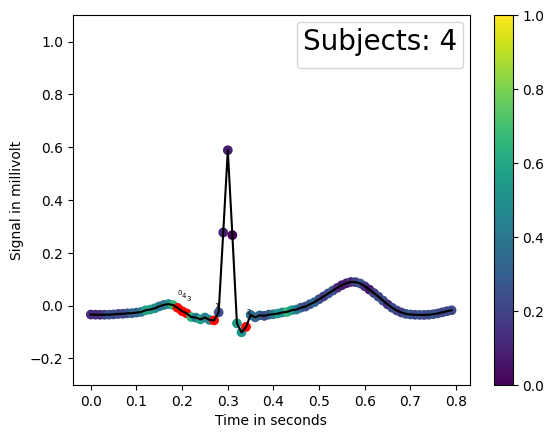

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 14


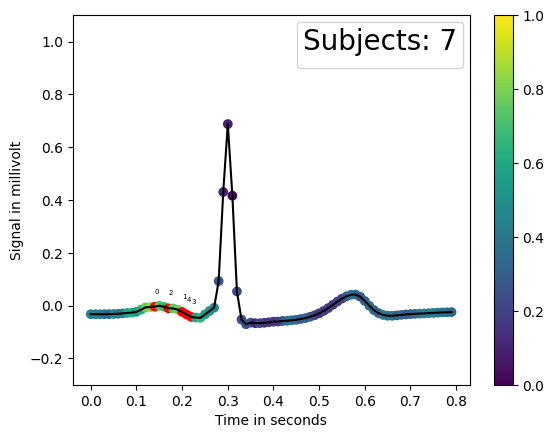

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Below this line: plot of mean-saliency-map of age bin 15


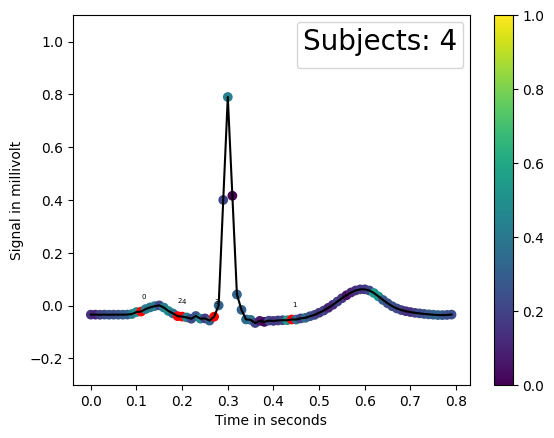

In [7]:
# this block takes ~17 minutes to compute with i5-1240p
in_parallel=False # not needed, saliency map creation already uses parallelization by default + 32GB RAM were not enough... do not activate

def get_mean_heartbeat_for_crops(saliency, crops_in, true_class, subject_id):
    grads = []
    peaks = []
    peaks_mean = False
    grads_mean = False
    ok=False
    msg = ""
    num_unusable_crops = 0
    
    # get saliency map for all crops
    # do the saliency map with respect to the prediction
    # Don't do: grads = saliency.attribute(crop_x) --> Could also be that something is predicted to a different age group
    # then it would be a wrong result when asking the model how it did predict for this age group
    grads_list = saliency.attribute(torch.stack(tuple(crops_in)).squeeze(dim=1), target=(true_class-1))
    # align the crops by peak
    # clean all crops
    for idx, crop_x in enumerate(crops_in):
        crop_numpy = crop_x.squeeze().detach().numpy()
        # deactivated cleaning crops since it cleans 3s-crops differently from the whole ecg, which is done for figure 7 in the paper
        clean_crop = crop_numpy#nk.ecg_clean(crop_numpy, sampling_rate=config.SAMPLING_RATE)
        sample_threshold=10
        optimal_lenght = config.SAMPLING_RATE * config.PIECE_LENGTH
        try:
            # if too many samples were cleaned away the peaks are shifted and the aligment will not work --> away with it!
            if (len(clean_crop) > optimal_lenght-sample_threshold):
                crop_peaks = nk.ecg_peaks(clean_crop, sampling_rate=config.SAMPLING_RATE)
                peaks_raw = crop_peaks[1]["ECG_R_Peaks"]
                p, s = get_peaks(crop_x, grads_list[idx].unsqueeze(0).abs(), peaks_raw)
                peaks.extend(p)
                grads.extend(s)
        except Exception as e:
            num_unusable_crops += 1

    if num_unusable_crops > 0:
        print(f'Number of ununsable crops after ecg-cleaning for subject {subject_id}: {num_unusable_crops}')

    if len(peaks) == 0:        
        msg = f"no heartbeats detected in {len(crops_in)} crops for subject {subject_id}"
    else:
        peaks_mean = torch.stack(peaks).mean(dim=0)
        grads_mean = torch.stack(grads).mean(dim=0)
        ok=True

    return ok, peaks_mean, grads_mean, msg

def get_peaks(crop_x, grads, peaks_raw):
    # from the 3-second crops get the heartbeats which are uncut
    time_left = 30
    time_right = 50
    peaks_org = []
    peaks_grads = []
    for peak_index in peaks_raw:
        left = peak_index - time_left
        right = peak_index + time_right
        if not ((left < 0) or (right > 300)):
            # ignore the other heartbeats, as they are not fully in the crop
            peak = crop_x[:, :, left:right]
            if grads is not None:
                saliency = grads[:, :, left:right]
                peaks_grads.append(saliency)
            peaks_org.append(peak)

    return peaks_org, peaks_grads

def visualize_and_save_one_crop_grad(raw_signal, w, savename_plot, num_subjects):
    # todo: colorscheme with 3 colors, white in the middle
    # + mark 5 most important data points

    # normalize gradients
    w_norm = (w - w.min()) / (w.max() - w.min())
    # get the indices of the 5 highest gradients
    highest_n = 5
    indice_of_higest_n_grads = np.argpartition(w_norm, -highest_n)[-highest_n:]
    # sort them
    indice_of_higest_n_grads = indice_of_higest_n_grads[np.argsort(w_norm[indice_of_higest_n_grads])]

    # create time axis with the correct scaling
    x_ = np.arange(0, len(raw_signal), 1)/config.SAMPLING_RATE
    # plot it
    cmap = plt.get_cmap("viridis")# see here: https://matplotlib.org/stable/gallery/color/colormap_reference.html
    colors = cmap(w_norm)
    colors[indice_of_higest_n_grads] = [1,0,0,1]
    plt.scatter(x_, raw_signal, c=colors)
    # annotate highest n values
    for cnt, my_grad_idx in enumerate(indice_of_higest_n_grads):
        plt.annotate(str(cnt), (x_[my_grad_idx], raw_signal[my_grad_idx]+0.05), fontsize=5)
        #plt.annotate(str(cnt), (x_[my_grad_idx], w_norm[my_grad_idx]))

    plt.plot(x_, raw_signal, c='black')
    #plt.plot(x_, raw_signal, c=colors)
    plt.ylim(-0.3,1.1) # so that the scaling is the same for all plots
    plt.legend(title=f'Subjects: {num_subjects}', title_fontsize=20, loc=1)
    plt.xlabel("Time in seconds")
    plt.ylabel("Signal in millivolt")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm)
    # save it
    plt.savefig(savename_plot,dpi=600)
    plt.show() # clears plt-buffer. DO NOT REMOVE! Otherwise the saved plots are empty ot look really weird


# load train-metadata-file
set_df = pd.read_csv(os.path.join(config.OUT_FOLDER, "train" + '_df.csv'))
# get age-bin-distribution
age_bin_distribution = set_df[config.LABEL_COLUMN_NAME].value_counts()


for age_bin in config.AGE_GROUPS:
    savename_peaks = os.path.join(saliency_folder, 'age_bin_' + str(age_bin) + '_peaks_mean.npy')
    savename_grads = os.path.join(saliency_folder, 'age_bin_' + str(age_bin) + '_grads_mean.npy')
    savename_plot = os.path.join(saliency_folder, 'sal-' + str(age_bin) + '-new.pdf')
    if (not os.path.exists(savename_peaks)) or (not os.path.exists(savename_grads)):
        # get subject-IDs of this age bin
        ids = set_df.loc[set_df[config.LABEL_COLUMN_NAME] == age_bin, 'ID'].values
        if in_parallel:
            results = Parallel(n_jobs=os.cpu_count())(delayed(get_mean_heartbeat_for_crops)(saliency, sample_id_to_crop_list[subject_id], sample_id_to_age_bin[subject_id], subject_id) for subject_id in ids)
        else:
            results = []
            for subject_id in ids:
                ok, peaks_mean, grads_mean, msg = get_mean_heartbeat_for_crops(saliency, sample_id_to_crop_list[subject_id], sample_id_to_age_bin[subject_id], subject_id)
                results.append([ok, peaks_mean, grads_mean, msg])
        #mean the data of the subjects
        overall_peaks_mean_list = []
        overall_grads_mean_list = []
        for ok, peaks_mean, grads_mean, message in results:
            if ok:
                overall_peaks_mean_list.append(peaks_mean.squeeze())
                overall_grads_mean_list.append(grads_mean.squeeze())
            else:
                print(message)
        
        age_bin_peaks_mean = np.mean(np.stack(overall_peaks_mean_list), axis=0)
        age_bin_grads_mean = np.mean(np.stack(overall_grads_mean_list), axis=0)
        # save the mean-beat-saliency-map-data of this age bin
        np.save(savename_peaks,age_bin_peaks_mean)
        np.save(savename_grads,age_bin_grads_mean)
    else:
        age_bin_peaks_mean = np.load(savename_peaks)
        age_bin_grads_mean = np.load(savename_grads)
        print(f'Loaded existing saliency-maps for age bin {age_bin}')
    
    print(f'Below this line: plot of mean-saliency-map of age bin {age_bin}')
    visualize_and_save_one_crop_grad(age_bin_peaks_mean, age_bin_grads_mean, savename_plot, age_bin_distribution[age_bin])